In [1]:
#Import pandas, geopandas, matplotlib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [17]:
#Read map data to geopandas dataframe, set CRS to BNG projection (EPSG:27700)
#LSOA data obtained from https://webarchive.nationalarchives.gov.uk/ukgwa/20160110200248/http://www.ons.gov.uk/ons/guide-method/geography/products/census/spatial/2011/index.html
englandwales = gpd.read_file('LSOA_2011_EW_BGC_V2.shp')
englandwales = englandwales.set_crs('epsg:27700')

In [18]:
#Select manchester borough LSOAs from englandwales dataframe
bolton = englandwales[englandwales['LSOA11NM'].str.contains("Bolton")]
bury = englandwales[englandwales['LSOA11NM'].str.contains("Bury")]
manchester = englandwales[englandwales['LSOA11NM'].str.contains("Manchester")]
oldham = englandwales[englandwales['LSOA11NM'].str.contains("Oldham")]
rochdale = englandwales[englandwales['LSOA11NM'].str.contains("Rochdale")]
salford = englandwales[englandwales['LSOA11NM'].str.contains("Salford")]
stockport = englandwales[englandwales['LSOA11NM'].str.contains("Stockport")]
tameside = englandwales[englandwales['LSOA11NM'].str.contains("Tameside")]
trafford = englandwales[englandwales['LSOA11NM'].str.contains("Trafford")]
wigan = englandwales[englandwales['LSOA11NM'].str.contains("Wigan")]

In [6]:
#Concatenate boroughs into single dataframe
boroughs = [bolton, bury, manchester, oldham, rochdale, salford, stockport, tameside, trafford, wigan]
greatermanchester = pd.concat(boroughs)

In [19]:
#Read pubs from https://www.getthedata.com/open-pubs into pandas dataframe, name columns, strip spaces from postcodes
pubs = pd.read_csv('open_pubs.csv', header=None)
pubs.columns = ['fsa_id', 'name', 'adddress', 'pcds', 'easting', 'northing', 'lat', 'long', 'local_authority']
pubs['pcds'] = pubs['pcds'].str.replace(' ', '')

In [20]:
#Read postcode lookup data into pandas dataframes
#Data obtained from https://geoportal.statistics.gov.uk/datasets/ons::national-statistics-postcode-lookup-november-2021/about
pclookupbl = pd.read_csv('NSPL_FEB_2022_UK_BL.csv')
pclookupm = pd.read_csv('NSPL_FEB_2022_UK_M.csv')
pclookupol = pd.read_csv('NSPL_FEB_2022_UK_OL.csv')
pclookupsk = pd.read_csv('NSPL_FEB_2022_UK_SK.csv')
pclookupwa = pd.read_csv('NSPL_FEB_2022_UK_WA.csv')
pclookupwn = pd.read_csv('NSPL_FEB_2022_UK_WN.csv')

In [21]:
#Concatenate all postcodes, strip spaces from pcds column
postcodes = [pclookupbl, pclookupm, pclookupol, pclookupsk, pclookupwa, pclookupwn]
gmpostcodes = pd.concat(postcodes)
gmpostcodes['pcds'] = gmpostcodes['pcds'].str.replace(' ', '')

In [22]:
#Join list of pubs with postcode lookup data, select only fsa_id and lsoa11 columns
publsoas = pubs.merge(gmpostcodes, on='pcds', how='left')
publsoas2 = publsoas[["fsa_id", "lsoa11"]]

In [23]:
#Group and aggregate data to give counts of pubs in each LSOA
lsoapubcounts = publsoas2.groupby(['lsoa11']).agg('count').reset_index()
lsoapubcounts.columns = ['LSOA11CD', 'count']

In [24]:
#Merge counts with map data. Set pub count to 0 for LSOAs with no pubs
graphdata = greatermanchester.merge(lsoapubcounts, on='LSOA11CD', how='left')
graphdata['count'] = graphdata['count'].fillna(0.1)

In [25]:
#Convert CRS to cartesian EPSG:3857, calculate area in km2, calculate pubs per km2 for each LSOA
graphdata2 = graphdata.to_crs('epsg:3857')
graphdata2['area'] = graphdata2['geometry'].area/ 10**6
graphdata2['pubsperkm2'] = graphdata2['count']/graphdata2['area']

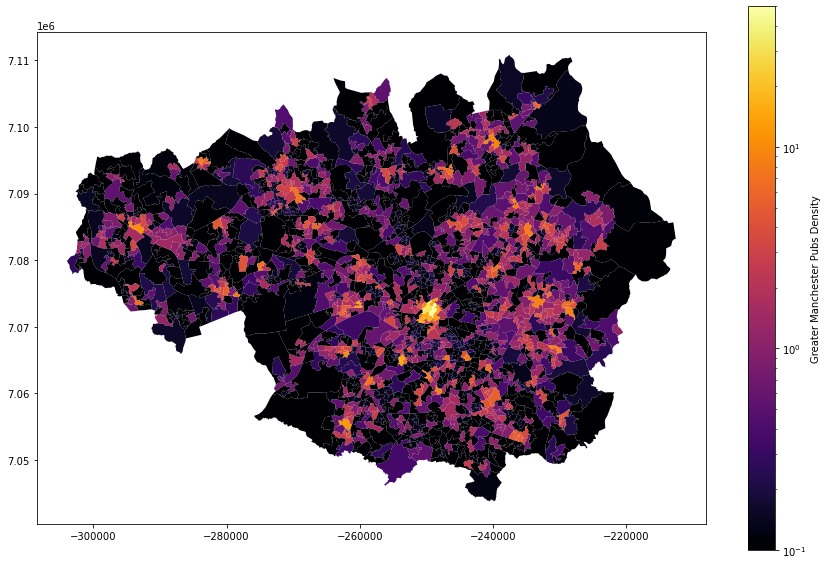

In [30]:
#Draw graph of pubs per km2
graphdata2.plot(column='pubsperkm2',
               figsize=(15, 10),
               legend=True,
               legend_kwds={'label': "Greater Manchester Pubs Density"},
               cmap='inferno',
               norm=colors.LogNorm(vmin=0.1, vmax=50))

#Save graph to .png file
plt.savefig('gmpubdensity.png', bbox_inches='tight', facecolor='w', dpi=400)